## Deploy  Price tag detection Model Package from AWS Marketplace 


This sample notebook shows you how to deploy <a href="your_url_here">Price tag detection (pridėti url, kai bus paleistas)</a> using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to <a href="your_url_here">Price tag detection (pridėti url, kai bus paleistas)</a>. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page <a href="your_url_here">Price tag detection (pridėti url, kai bus paleistas)</a>.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [1]:
model_package_arn='arn:aws:sagemaker:eu-west-1:720538024868:model-package/price-tag-detection-nr6-copy-04-30'

In [2]:
import base64
import boto3
import cv2
import json 
import sagemaker as sage
from sagemaker import ModelPackage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from IPython.display import display
from PIL import Image

In [3]:
role = get_execution_role() # default role
# role = '' # if you have specific role
sagemaker_session = sage.Session()
bucket=sagemaker_session.default_bucket() # default bucket
# bucket='' # if you want specific bucket
runtime= boto3.client('runtime.sagemaker')

### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [4]:
model_name='pricetag-detection-marketplace'
content_type='application/x-image'
real_time_inference_instance_type='ml.m5.large'

#### A. Create an endpoint

In [5]:
#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session)

#Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

-------------!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

##### Load image

In [6]:
img = cv2.imread('data/input/real-time/test_price-tag.jpg')

<Add code snippet that shows the payload contents>

##### Create request body

In [7]:
from utils.utils import image_to_json
# Set threshold, default is 0.5
threshold = 0.5
request_json = image_to_json(img, threshold)

#### C. Perform real-time inference

In [9]:
response = runtime.invoke_endpoint(
    EndpointName=model_name, 
    ContentType=content_type,
    Accept="application/json",
    Body=request_json
    )

##### Read response

In [10]:
response_body = json.loads(response['Body'].read())
predictions = response_body['predictions']

#### D. Visualize output

##### Copy image and draw response annotations

In [11]:
from copy import deepcopy
new_img = deepcopy(img)
for prediction in predictions:
    x_min, y_min, x_max, y_max, score = prediction.values()
    score = round(score, 2)
    cv2.rectangle(new_img, (int(x_min), int(y_min)),
                              (int(x_max), int(y_max)), (255, 0, 0), 2)
    cv2.putText(new_img, f'{score}', (int(x_min), int(y_min - 10)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 255, 0), 4)

##### Display image with recognized price tags and their recognition confidence

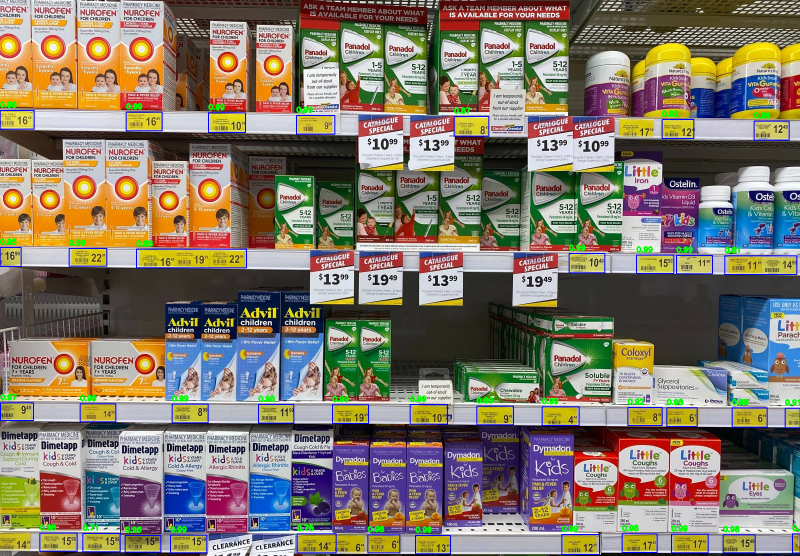

In [12]:
from utils.utils import image_resize
new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
resized = image_resize(new_img, width=800)
resized.shape
display(Image.fromarray(resized))

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [13]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

### 4. Clean-up

#### A. Delete the model

In [14]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

